<a href="https://colab.research.google.com/github/pvhau169/MLTSA22_HPhan/blob/main/HW9/HP_HW9_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/UDStuff/MachineLearningForTimeSeries/HW7/

Mounted at /content/gdrive
/content/gdrive/MyDrive/UDStuff/MachineLearningForTimeSeries/HW7


In [ ]:
import numpy as np

In [ ]:
import pandas as pd
data = np.load('process_dawta.numpy.npy')
lcvs = pd.read_csv("training_set.csv")
meta_data = pd.read_csv('training_set_metadata.csv')
meta_data.head()
lcvs.shape

(1421705, 6)

In [ ]:
data.shape

(7848, 6, 50)

preprocess Plasticc data: 7848 objects, 6 passbands, timeseries length 50

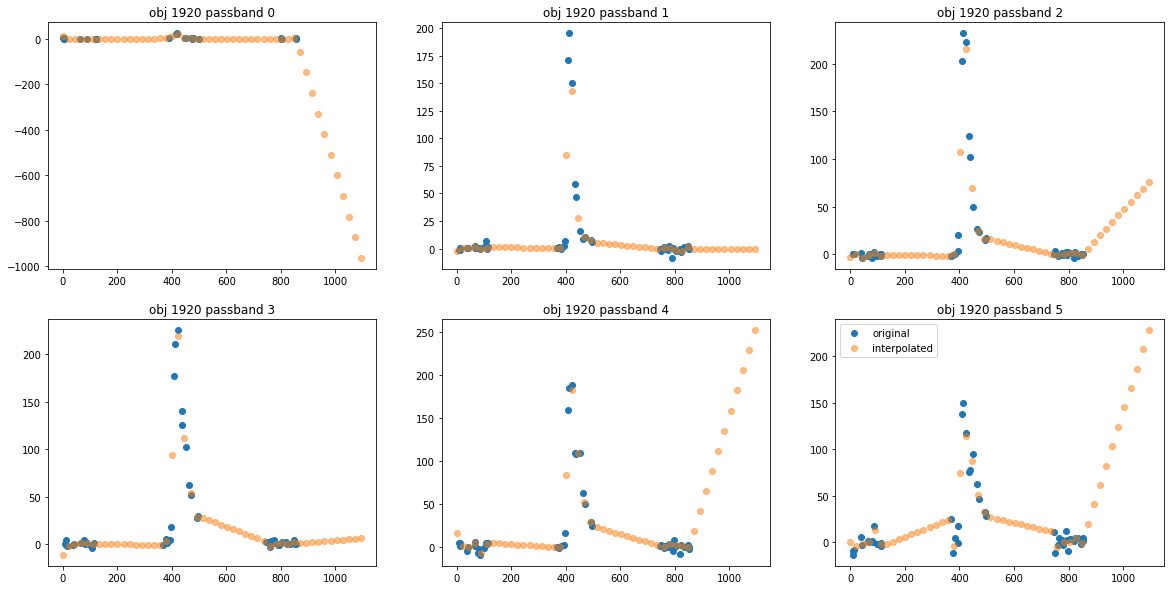

In [ ]:
fig = plt.figure(figsize = (20, 10))
axes = []
obj_index = 8
obj_id = obj_ids[obj_index]

for passband in range(6):
  axes.append(fig.add_subplot(2, 3, passband+1))

  mask = (lcvs['object_id'] == obj_id) & (lcvs['passband'] == passband)

  y = lcvs['flux'][mask]
  x = lcvs['mjd'][mask]
  axes[-1].scatter(x-min_time_stamp, y, label='original')
  axes[-1].scatter(time, data[obj_index][passband], label = 'interpolated', alpha = 0.5)
  axes[-1].set_title("obj {} passband {}".format(obj_id, passband))
plt.legend()

From what I understand, flux timeseries as different passband have different scales. Therefore I dont want combine 6 flux timeseries as different passband as input to autoencoder.

Fortunately, I preprocess the timeseries to have same length. In order to train autoencoder to denoise the lux timeseries, I treat all timeseries at different passband same => my training data set has 7848x6 samples

In [ ]:
auto_encoder_input = data.reshape(-1, 50)
auto_encoder_input.shape

feature_dim = auto_encoder_input.shape[1]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf


def getAutoEncoderModel():
  model = Sequential()
  # encoder

  model.add(Dense(64, activation='relu', input_dim=feature_dim))
  model.add(Dense(32, activation='relu'))

  #bottle neck
  model.add(Dense(16, activation='relu'))


  #decoder
  model.add(Dense(32, activation='relu'))
  model.add(Dense(64, activation='relu'))

  #output layer
  model.add(Dense(feature_dim, activation='linear'))

  return model

In [ ]:
# optimizer = Adam, learning rate = 0.01, batchs_size = 100
#model is training with earlystopping

model = getAutoEncoderModel()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mean_squared_error")

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose = 1, restore_best_weights=True)
hist_auto_encoder = model.fit(auto_encoder_input, auto_encoder_input, validation_split = 0.25,
                               epochs=100, batch_size=100, verbose=2)#, callbacks=[callback])

Epoch 1/100
354/354 - 2s - loss: 238429216.0000 - val_loss: 80269464.0000 - 2s/epoch - 5ms/step
Epoch 2/100
354/354 - 1s - loss: 88875832.0000 - val_loss: 84105144.0000 - 1s/epoch - 4ms/step
Epoch 3/100
354/354 - 1s - loss: 107995080.0000 - val_loss: 71878984.0000 - 1s/epoch - 3ms/step
Epoch 4/100
354/354 - 1s - loss: 64395524.0000 - val_loss: 87519768.0000 - 1s/epoch - 3ms/step
Epoch 5/100
354/354 - 1s - loss: 68361232.0000 - val_loss: 88686464.0000 - 1s/epoch - 3ms/step
Epoch 6/100
354/354 - 1s - loss: 111897936.0000 - val_loss: 132198992.0000 - 1s/epoch - 3ms/step
Epoch 7/100
354/354 - 1s - loss: 752932288.0000 - val_loss: 66750904.0000 - 1s/epoch - 3ms/step
Epoch 8/100
354/354 - 1s - loss: 45672564.0000 - val_loss: 99827104.0000 - 1s/epoch - 4ms/step
Epoch 9/100
354/354 - 1s - loss: 96997312.0000 - val_loss: 92450640.0000 - 1s/epoch - 3ms/step
Epoch 10/100
354/354 - 1s - loss: 302054496.0000 - val_loss: 69284048.0000 - 988ms/epoch - 3ms/step
Epoch 11/100
354/354 - 1s - loss: 106044

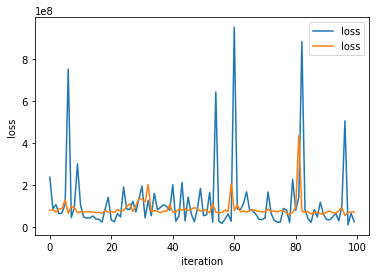

In [ ]:
plt.plot(hist_auto_encoder.history['loss'], label = 'loss')
plt.plot(hist_auto_encoder.history['val_loss'], label = 'loss')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend()

spikes in loss curve may come from small batch size, however, the val_loss looks more stable

In [ ]:
auto_encoder_output = model(auto_encoder_input).numpy().reshape(data.shape)
auto_encoder_output.shape

(7848, 6, 50)

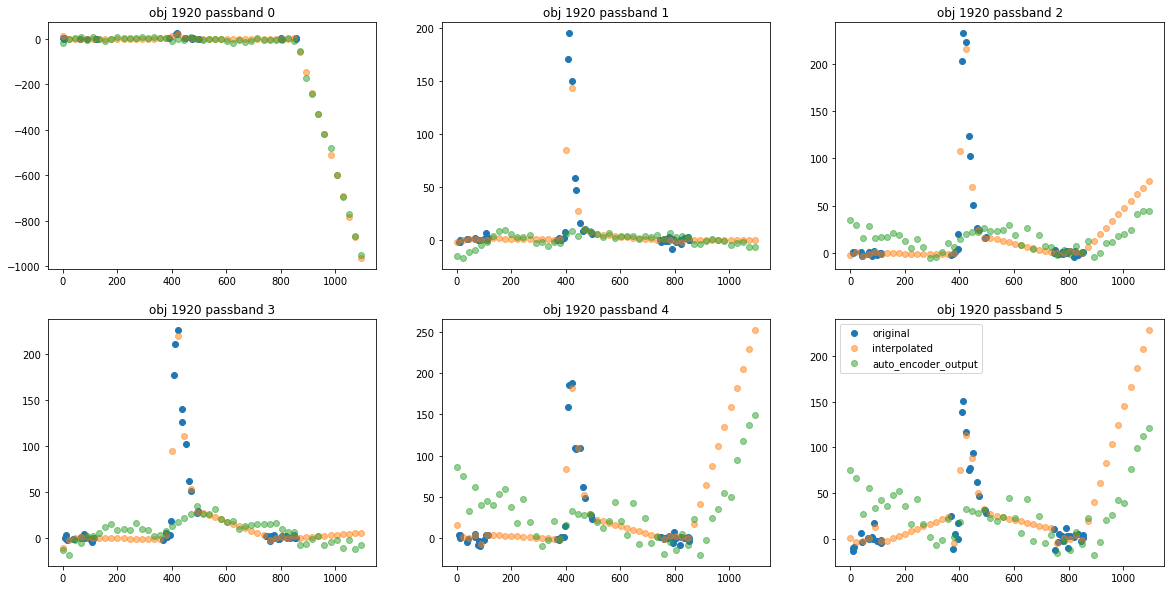

In [ ]:
fig = plt.figure(figsize = (20, 10))
axes = []
obj_index = 8
obj_id = obj_ids[obj_index]

for passband in range(6):
  axes.append(fig.add_subplot(2, 3, passband+1))

  mask = (lcvs['object_id'] == obj_id) & (lcvs['passband'] == passband)

  y = lcvs['flux'][mask]
  x = lcvs['mjd'][mask]
  axes[-1].scatter(x-min_time_stamp, y, label='original')
  axes[-1].scatter(time, data[obj_index][passband], label = 'interpolated', alpha = 0.5)
  axes[-1].scatter(time, auto_encoder_output[obj_index][passband], label = 'auto_encoder_output', alpha = 0.5)
  axes[-1].set_title("obj {} passband {}".format(obj_id, passband))
plt.legend()

Output from autoencoder. It seems like the autoencoder output cut out the trend of timeseries

<font color="red"> FBB ok (cut = caught? )</font>

# Extracted Features from HW7

In [ ]:

features = pd.read_csv("extractedFeatures.csv")
features.head()

,object_id,0_mean,0_std,0_slope,0_std_err,1_mean,1_std,1_slope,1_std_err,2_mean,...,4_mean,4_std,4_slope,4_std_err,5_mean,5_std,5_slope,5_std_err,decl,ddf
0,615.0,-3.254554,83.275842,0.000528,0.000461,-385.699911,596.576924,0.000564,0.000419,-134.146566,...,-55.954592,289.276965,0.001046,0.000402,-47.449847,292.182295,0.001012,0.000410,-61.943836,1.0
1,713.0,-2.720398,7.062516,-0.002880,0.000200,-1.019804,5.661101,-0.002824,0.000212,-0.794238,...,-0.900262,6.349526,-0.002706,0.000239,-1.794175,7.030448,-0.001996,0.000345,-27.784405,1.0
2,730.0,-0.048080,1.816127,-0.000122,0.000379,0.141057,1.789767,0.000341,0.000474,2.400870,...,4.308728,10.604821,0.001492,0.000426,4.539396,13.201397,0.001271,0.000440,-6.579593,1.0
3,745.0,1.797523,4.343961,-0.000705,0.000412,5.717394,25.731788,-0.000093,0.000439,9.711532,...,13.134436,32.772464,-0.000109,0.000439,10.746138,25.822133,0.000003,0.000444,-45.586655,1.0
4,1124.0,0.660948,2.341279,0.001244,0.000438,4.634637,8.037329,0.001881,0.000343,10.243968,...,9.906102,26.633303,0.001356,0.000385,6.896742,21.245772,0.001120,0.000405,-63.823658,1.0


In [ ]:
features.shape

(7848, 27)

My extracted features data from HW 7has shape of 7848 x 26, where 7848 is the number of object. 27 features are consists of 24 features are mean, std, slop, std_err of 6 passband and 2 features of decl and ddf

<font color="red"> FBB ok

# AUtoEncoder Bottle neck as features

In [ ]:
from keras import Model

bottle_neck = Model(inputs=model.input, outputs = model.layers[2].output)
bottle_neck_features = bottle_neck.predict(auto_encoder_input).reshape(data.shape[:2] + (16,))
bottle_neck_features.shape

(7848, 6, 16)

In [ ]:
bottle_neck_features = bottle_neck_features.reshape(bottle_neck_features.shape[0], -1)

In [ ]:
bottle_neck_features.shape

(7848, 96)

Each passband timeseries will be compressed into 16features ( size of bottle neck). Therefore the compressed features of each object have size of 6x16 = 96

In [ ]:

X_data = features.copy()
labels = meta_data['target']

In [ ]:
print(labels.shape)
print("unique labels :", np.unique(labels))

(7848,)
unique labels : [ 6 15 16 42 52 53 62 64 65 67 88 90 92 95]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, labels, test_size=0.25, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(5886, 27) (1962, 27)
(5886,) (1962,)


75% of data will be used as training data, the rest is testing data

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# train classification model with extracted fetures only
from sklearn.metrics import f1_score
X_data = features.copy()
labels = meta_data['target']
X_train, X_test, y_train, y_test = train_test_split(X_data, labels, test_size=0.25, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

f1_score_extracted = f1_score(y_test, y_pred, average='macro')

In [ ]:
# Retrain classification model with compressed features only
from sklearn.metrics import f1_score
X_data = bottle_neck_features.copy()
labels = meta_data['target']
X_train, X_test, y_train, y_test = train_test_split(X_data, labels, test_size=0.25, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

f1_score_bottle_neck = f1_score(y_test, y_pred, average='macro')

In [ ]:
# Retrain classification model with combined features
from sklearn.metrics import f1_score
X_data = np.concatenate((features.copy(), bottle_neck_features), axis = -1)
labels = meta_data['target']
X_train, X_test, y_train, y_test = train_test_split(X_data, labels, test_size=0.25, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

f1_score_combine = f1_score(y_test, y_pred, average='macro')

In [ ]:
print("F1 score with extracted features only = ", f1_score_extracted)
print("F1 score with bottle neck features only = ", f1_score_bottle_neck)
print("F1 score with combined features = ", f1_score_combine)

F1 score with extracted features only =  0.4942709559719612
F1 score with bottle neck features only =  0.27743175534353837
F1 score with combined features =  0.42958356640018086


Based on F1 score, the classification model work best with only extracted features from HW7, the bottle neck features from auto encoder just make model confused, and lead to bad prediction

<font color="red"> FBB if you did a confusion matrix you would probably find out that the inbalance in the data is causing your issues. Other thsn that I think the interpolation is the issues: linear interpolation produces features that are not consistent with the data. but overall good!